In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# define a dropout instance and make some data
prob = .5

dropout = nn.Dropout(p = prob)
x = torch.ones(10)

# implementing 
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([0., 2., 0., 0., 2., 0., 2., 2., 2., 0.])
tensor(1.)


In [11]:
# dropout is turned off when evaluating the model
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [15]:
# F.dropout is a alternative and it is not turned of in eval mode
dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))

tensor([0., 0., 0., 2., 2., 0., 0., 2., 2., 0.])
tensor(0.8000)


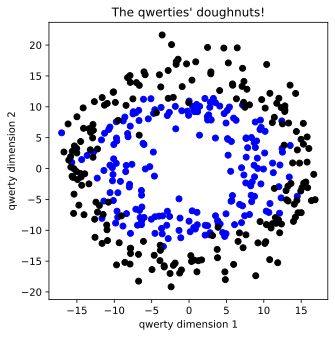

In [31]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bo')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [32]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2)

# then convert them into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batch_size = 16
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)



In [33]:
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        ### layers
        self.input  = nn.Linear(  2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128, 1)

        # parameters
        self.dr = dropoutRate

    
    # forward pass
    def forward(self, X):

        # pass the data through the input layer
        X = F.relu(self.input(X))

        # dropout after input layer
        X = F.dropout(X, p = self.dr, training = self.training)

        # pass  the data through the hidden layer
        X = F.relu(self.hidden(X))

        # dropout after hidden layer
        X = F.dropout(X, p = self.dr, training = self.training)

        # output layer
        X = self.output(X)

        return X

In [34]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat


tensor([[ 0.1995],
        [ 0.1085],
        [ 0.0832],
        [ 0.3931],
        [-0.0633],
        [ 0.1408],
        [ 0.3668],
        [-0.0561],
        [ 0.1113],
        [ 0.0979]], grad_fn=<AddmmBackward0>)

In [35]:
def createANewModel(dropoutrate):

    # instance of the model class
    ANNQC = theModelClass(dropoutrate)

    # loss function
    lossfun  = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr = 0.002)

    return ANNQC, lossfun, optimizer

In [36]:
numepochs = 1000

def trainTheModel(ANNQC, lossfun, optimizer):

    # initialize accuracies as emties 
    trainAcc = []
    testAcc = []

    
    

    for epochi in range(numepochs):
        # switch training mode on
        ANNQC.train()
        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:
            yHat = ANNQC(X)
            loss = lossfun(yHat,y)

            #  back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean(((yHat>.5) == y).float()).item())

        trainAcc.append(np.mean(batchAcc))
        ANNQC.eval()
        X, y = next(iter(test_loader))
        yHat = ANNQC(X)
        testAcc.append(100*torch.mean(((yHat>0.5)==y).float()).item())
    
    return trainAcc, testAcc


In [47]:
# create a model 
dropout = .0
ANNQC, lossfun, optimizer = createANewModel(dropout)

# train the model
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

In [55]:
def smooth(x, k = 20):
    return np.convolve(x, np.ones(k)/k, mode = 'same')

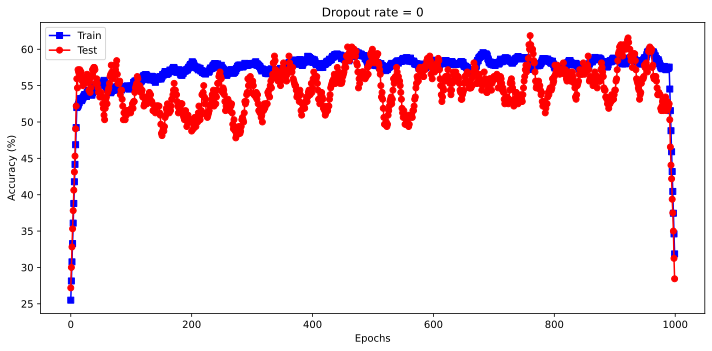

In [56]:
# plot the results 
fig = plt.figure(figsize = (10, 5))

plt.plot(smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropout)
plt.tight_layout()
plt.show()

In [50]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNQC,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])

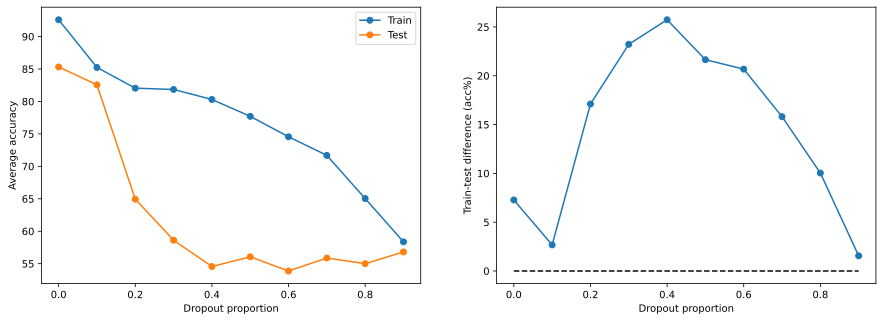

In [51]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()